In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ISLP.models
import scipy.stats
from scipy.stats import t
from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.stats.diagnostic import het_breuschpagan

# 线性回归系数的假设检验

## 概述

本 Jupyter Notebook 聚焦于使用波士顿房价数据集进行线性回归系数的假设检验。通过本节学习，您将理解如何计算模型的拟合优度，以及在线性回归模型中检验自变量与因变量之间关系的显著性。具体来说，您将：

- 计算拟合优度：计算 $R^2$ 和均方根误差（root mean square error），并学习如何解释这些指标。
- 进行假设检验：
  - 构建零假设和备择假设以检验回归系数的显著性。
  - 计算斜率的标准误差以及检验统计量（t-统计量）。
  - 确定 p 值并基于显著性水平做出决策。

## 使用合成数据测试拟合优度

我们将使用合成数据来理解用于量化线性回归模型中拟合优度的工具。

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     831.9
Date:                Mon, 04 Nov 2024   Prob (F-statistic):           3.04e-88
Time:                        00:56:11   Log-Likelihood:                -422.98
No. Observations:                 300   AIC:                             850.0
Df Residuals:                     298   BIC:                             857.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0408      0.115     35.129      0.0

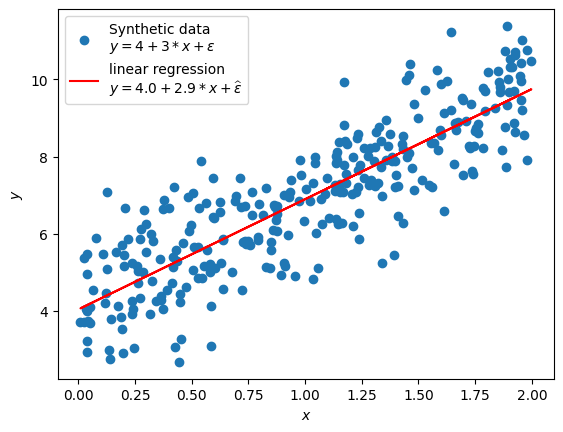

In [62]:
np.random.seed(0)
num_of_points = 300
beta_0 = 4
beta_1 = 3
x = 2 * np.random.rand(num_of_points, 1)
y = beta_0 + beta_1 * x + np.random.randn(num_of_points, 1)

plt.scatter(
    x, y, label="Synthetic data \n" rf"$y = {beta_0} + {beta_1} * x + \varepsilon$"
)

x_with_intercept = add_constant(x)
model = OLS(y, x_with_intercept)
results = model.fit()
print(results.summary())
beta_0_hat, beta_1_hat = results.params
y_hat = results.predict(x_with_intercept)

plt.plot(
    x,
    y_hat,
    "r",
    label="linear regression \n"
    rf"$y = {beta_0_hat:.2} + {beta_1_hat:.2} * x + \widehat\varepsilon$",
)
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

我们希望对零假设进行检验：
$$
H_0: \beta^*_1 = 0
$$
$$
H_1: \beta^*_1 \neq 0
$$
为此，我们在以下假设下进行工作：

- 回归函数是线性的；
- 观测值 $(Y_i ,X_i )_{1 \leq i \leq n}$ 是独立同分布（iid）的；
- 条件方差 $\sigma^2 = Var(Y |X ) = Var(\varepsilon)$ 是恒定的；
- $\varepsilon$ 服从高斯分布。

首先，我们可以通过公式 $\widehat\varepsilon = \widehat y - y$ 计算估计残差，并检查它们是否服从高斯分布：

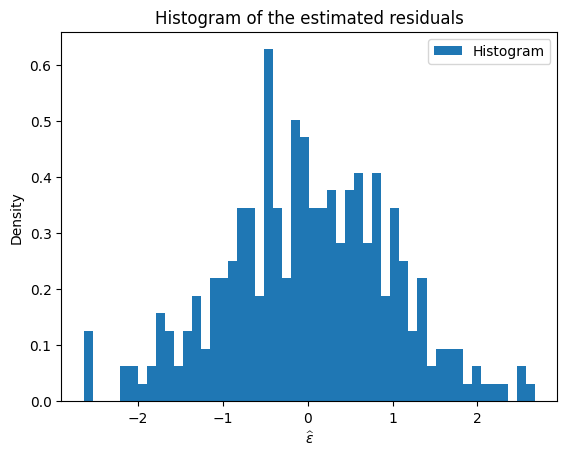

In [63]:
estimated_residuals = results.resid
plt.hist(estimated_residuals, bins=50, density=True, label="Histogram")
plt.legend()
plt.title("Histogram of the estimated residuals")
plt.xlabel(r"$\widehat\varepsilon$")
plt.ylabel("Density")
plt.show()

为了确认这一点，我们可以在残差的直方图上叠加一条正态分布曲线，并观察两者的差异。

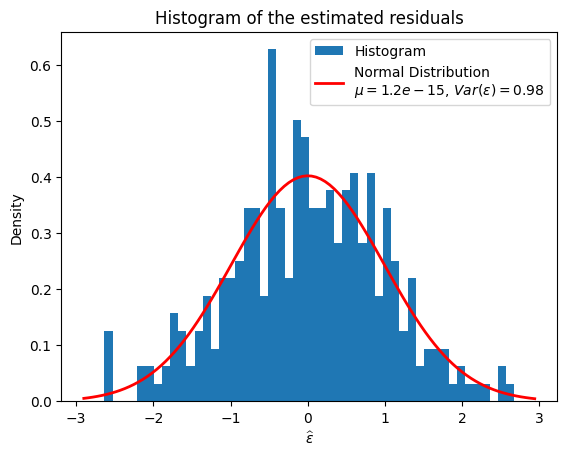

In [64]:
plt.hist(estimated_residuals, bins=50, density=True, label="Histogram")
xmin, xmax = plt.xlim()

mean, std_dev = np.mean(estimated_residuals), np.std(estimated_residuals)
x_normal = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x_normal, mean, std_dev)

plt.plot(
    x_normal,
    p,
    "r",
    linewidth=2,
    label="Normal Distribution\n"
    rf"$\mu={mean:.2}$, $Var(\varepsilon)={np.var(estimated_residuals):.2}$",
)

plt.legend()
plt.title("Histogram of the estimated residuals")
plt.xlabel(r"$\widehat\varepsilon$")
plt.ylabel("Density")
plt.show()

估计残差的均值大约在零附近，这是符合预期的。那么，如何判断其分布是否真的为正态分布呢？

我们可以通过绘制 Q-Q 图（Quantile-Quantile Plot）来确认。如果数据点偏离理论预测线，那么它们就不是正态分布。此外，Shapiro-Wilk 检验也是一种正态性检验方法。如果 p 值小于 0.05，则表明估计残差与正态分布有显著差异（即，它们不符合正态分布）。

Shapiro-Wilk Test: 
W-statistic=0.997, 
p-value=0.857

It is a normal distribution



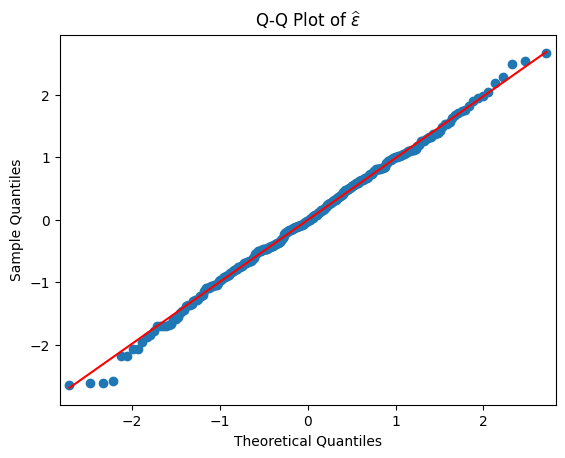

In [65]:
qqplot(estimated_residuals.flatten(), line="s")
plt.title(r"Q-Q Plot of $\widehat\varepsilon$")
shapiro_test = scipy.stats.shapiro(estimated_residuals)
print(
    f"Shapiro-Wilk Test: \nW-statistic={shapiro_test.statistic:.3}, \np-value={shapiro_test.pvalue:.3}"
)
if shapiro_test.pvalue < 0.05:
    print("\nNot a normal distribution\n")
else:
    print("\nIt is a normal distribution\n")

Q-Q 图看起来良好。接下来，我们来看 Shapiro-Wilk 检验。若 p 值大于 $0.05$，Shapiro-Wilk 检验也确认该分布为正态分布。

现在我们将检查估计残差的同方差性（Homoscedasticity），方法是绘制残差与拟合值 $\widehat y$ 的散点图。如果估计残差在零附近随机分布且没有明显的模式，则表明方差可能是恒定的（同方差）。

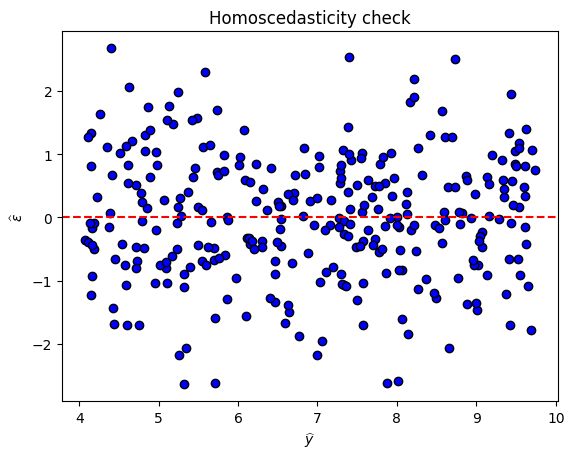

In [66]:
plt.scatter(y_hat, estimated_residuals, color="blue", edgecolor="k")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Homoscedasticity check")
plt.xlabel(r"$\widehat y$")
plt.ylabel(r"$\widehat\varepsilon$")
plt.show()

看起来不错！残差随机分布，且分布宽度没有变化。接下来我们可以通过 Breusch-Pagan 检验进行确认。该检验正式评估 $Var(\varepsilon)$ 是否恒定。如果 p 值小于 $0.05$，则表明残差存在异方差性（即，方差不恒定）。

In [67]:
x_with_const = add_constant(x)
bp_test = het_breuschpagan(estimated_residuals, x_with_const)
labels = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test_results = dict(zip(labels, bp_test))

for k, v in test_results.items():
    print(f"{k}: {v}")

if test_results["f p-value"] < 0.05:
    print("\nHeteroscedasticity: The variance is NOT constant\n")
else:
    print("\nHomoscedasticity: The variance is constant\n")

Lagrange multiplier statistic: 1.0094396311893017
p-value: 0.31503712345957835
f-value: 1.0060953420180025
f p-value: 0.3166538592783117

Homoscedasticity: The variance is constant



现在我们已经检查了进行假设检验的基本条件，接下来我们将检验我们的假设。

# 假设检验

在线性回归中，假设检验有助于确定自变量和因变量之间的关系是否具有统计显著性。

### 假设的构建

- **原假设 (\(H_0\))**: \($\beta_1 = 0$\)
  - 此假设认为自变量（`lstat`）和因变量（`medv`）之间没有关系。换句话说，回归线的斜率为零。

- **备择假设 (\(H_1\))**: \($\beta_1 \neq 0$\)
  - 此假设认为自变量和因变量之间存在关系，回归线的斜率不为零。

### 假设检验的步骤

1. **计算回归系数**：
   - 使用协方差和方差计算回归线的斜率 \($\hat{\beta}_1$\) 和截距 \($\hat{\beta}_0$\)。

2. **计算标准误差**：
   - 计算斜率的标准误差 \($\text{SE}(\hat{\beta}_1)$\)，这衡量了斜率估计的变异性。

3. **计算检验统计量**：
   - 斜率的 t 统计量为：
     $$
     t = \frac{\hat{\beta}_1 - 0}{\text{SE}(\hat{\beta}_1)}
     $$
   - 这里 \($\hat{\beta}_1$\) 是估计的斜率，\($0$\) 是在原假设下的假设值。

4. **确定 p 值**：
   - 使用 t 统计量从 t 分布中找到 p 值。p 值表示在原假设成立的情况下，观察到的检验统计量同样极端或更极端的概率。

5. **做出决策**：
   - 将 p 值与显著性水平（例如 \($\alpha = 0.05$\)）进行比较。如果 p 值小于 \($\alpha$\)，则拒绝原假设；否则，不拒绝原假设。

### 实现
由于我们使用 `statsmodels` 包，我们可以从 `results` 对象中获取 p 值：

In [68]:
p_value = results.pvalues[1]
print(p_value)

3.0447713854719384e-88


## 理解假设检验中的 p 值

p 值是假设检验中的一个基本概念，帮助我们判断是否应该拒绝原假设（$H_0$）。在线性回归的背景下，p 值衡量了针对原假设的证据强度，即假设自变量系数等于零（即预测变量和目标变量之间没有关系）的情况。

### 什么是 p 值？

p 值表示在假设原假设（$H_0$）为真的前提下，获得一个同样极端或更极端的检验统计量（例如 t 统计量）的概率。更直观地，它告诉我们观察到的效果（或更极端的效果）仅仅由于偶然出现的可能性有多大。

### 解读 p 值：

**高 p 值（例如 $p>0.05$）**：这表明数据没有提供足够的证据来反对原假设。因此，我们不能拒绝 $H_0$，这意味着该预测变量可能在解释因变量时不具统计显著性。

**低 p 值（例如 $p\leq0.05$）**：这表明数据提供了强有力的证据反对原假设。因此，我们拒绝 $H_0$，表明该预测变量在解释因变量时具有统计显著性。

### 解读我们的结果

我们正在检验 `lstat`（低收入人口百分比）和 `medv`（房价中位数）之间的关系。

**原假设**：`lstat` 和 `medv` 之间没有关系（即回归线的斜率为零，$\beta_1=0$）

**备择假设**：`lstat` 和 `medv` 之间存在关系（即回归线的斜率不为零，$\beta_1\neq0$）

运行线性回归模型后，我们得到 `lstat` 系数的 p 值约为 $p\approx0$。这意味着我们有充足的证据拒绝原假设，表明 `lstat` 对房价 (`medv`) 有显著影响，并且这种效果由偶然产生的可能性极低（约为 $0\%$）。

**低 p 值的意义可视化**：
低 p 值表明预测变量与响应变量之间观察到的关系不太可能由随机偶然产生。可以通过绘制在原假设下的检验统计量（t 统计量）分布来可视化这一点：

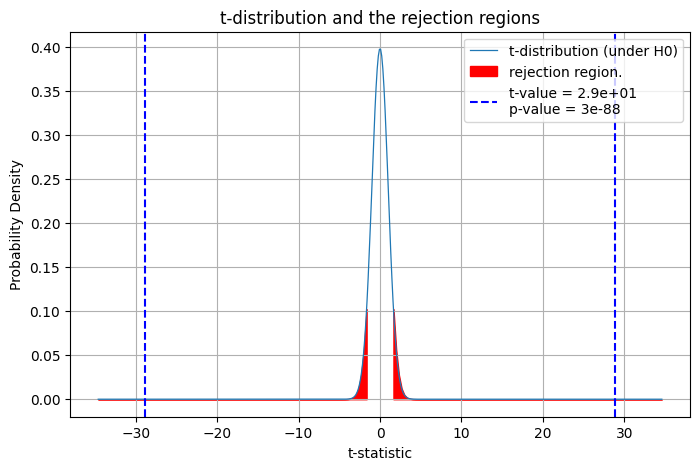

In [69]:
degrees_of_freedom = num_of_points
t_value = results.tvalues[1]

# plot the t-distribution for the given dof
x_plotting_range = 1.2 * np.abs(t_value)
x_t = np.linspace(-x_plotting_range, x_plotting_range, 500)
t_dist = t.pdf(x_t, degrees_of_freedom)
plt.figure(figsize=(8, 5))
plt.plot(x_t, t_dist, label="t-distribution (under H0)", lw=0.9)


# Visualise the rejection regeon:
significance_level = 0.05
t_score_significance_level = t.ppf(1 - significance_level, degrees_of_freedom)

x_fill = np.linspace(x_plotting_range, abs(t_score_significance_level), 100)
y_fill = t.pdf(x_fill, degrees_of_freedom)

plt.fill_between(-x_fill, y_fill, color="red", alpha=1, label="rejection region.")
plt.fill_between(x_fill, y_fill, color="red", alpha=1)

# Plot the t_value
plt.axvline(
    x=t_value,
    color="blue",
    linestyle="--",
    label=f"t-value = {t_value:.2}\np-value = {p_value:0.2}",
)
plt.axvline(x=-t_value, color="blue", linestyle="--")

plt.title("t-distribution and the rejection regions")
plt.xlabel("t-statistic")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()

好的，接下来我们将这些步骤应用到真实数据中：

1. **拟合线性回归模型**：
   - 我们将使用真实数据集来拟合一个线性回归模型，确定自变量与因变量之间的关系。

2. **计算 $\widehat\varepsilon$（残差）**：
   - 根据拟合模型计算估计残差 $\widehat\varepsilon = \widehat y - y$。

3. **检查 $\widehat\varepsilon$ 的分布**：
   - 通过绘制直方图或 Q-Q 图来检查残差是否呈正态分布，并使用 Shapiro-Wilk 检验进一步确认。

4. **检查 $Var(\widehat\varepsilon)$ 是否恒定**：
   - 通过绘制残差与拟合值 $\widehat y$ 的散点图来评估同方差性，并进行 Breusch-Pagan 检验确认残差方差是否恒定。

5. **检验原假设**：
   - 根据计算的回归系数、标准误差和 t 统计量，检验原假设（$H_0: \beta_1 = 0$）。通过 p 值决定是否拒绝原假设，从而判断自变量对因变量的显著性。

我们现在可以逐步实现这些分析步骤。

## 加载数据

和之前一样，我们将使用 "Boston" 示例数据集。

In [70]:
data_boston = ISLP.load_data("Boston")

## 线性回归

我们首先将针对 `lstat` 和 `medv` 数据拟合一个线性模型，就像我们在之前的 Notebook 中所做的一样：

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Mon, 04 Nov 2024   Prob (F-statistic):           5.08e-88
Time:                        00:56:12   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.5538      0.563     61.415      0.0

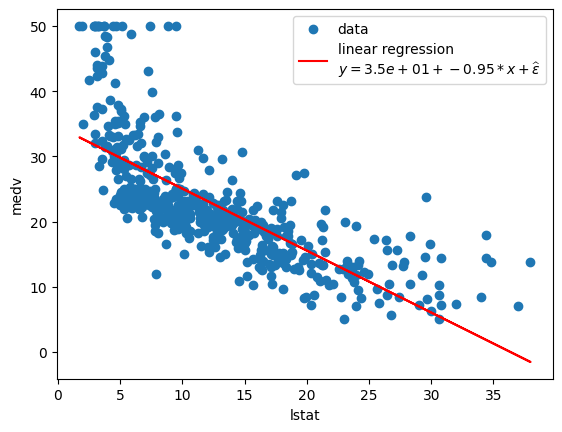

In [71]:
x_column_name = "lstat"
y_column_name = "medv"

x_column = data_boston[x_column_name]
y_column = data_boston[y_column_name]

x_matrix = add_constant(x_column)
y = y_column
model = OLS(y, x_matrix)
results = model.fit()
print(results.summary())

beta_0_hat, beta_1_hat = results.params
y_hat = results.predict(x_matrix)

plt.scatter(x_column, y_column, label="data")
plt.plot(
    x_column,
    y_hat,
    "r",
    label="linear regression \n"
    rf"$y = {beta_0_hat:.2} + {beta_1_hat:.2} * x + \widehat\varepsilon$",
)
plt.legend()
plt.xlabel("lstat")
plt.ylabel("medv")
plt.show()

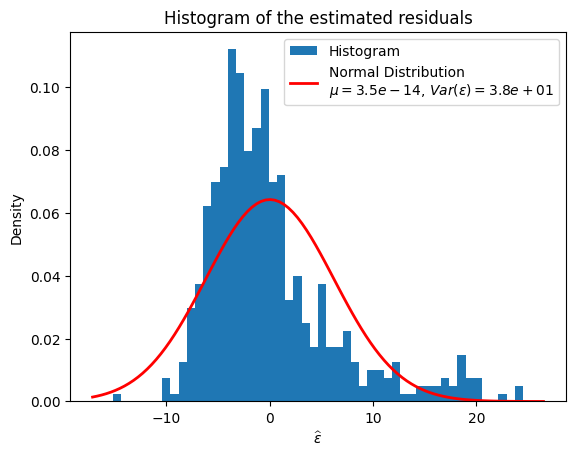

In [72]:
estimated_residuals = results.resid

plt.hist(estimated_residuals, bins=50, density=True, label="Histogram")
xmin, xmax = plt.xlim()

mean, std_dev = np.mean(estimated_residuals), np.std(estimated_residuals)
x_normal = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x_normal, mean, std_dev)

plt.plot(
    x_normal,
    p,
    "r",
    linewidth=2,
    label="Normal Distribution\n"
    rf"$\mu={mean:.2}$, $Var(\varepsilon)={np.var(estimated_residuals):.2}$",
)

plt.legend()
plt.title("Histogram of the estimated residuals")
plt.xlabel(r"$\widehat\varepsilon$")
plt.ylabel("Density")
plt.show()

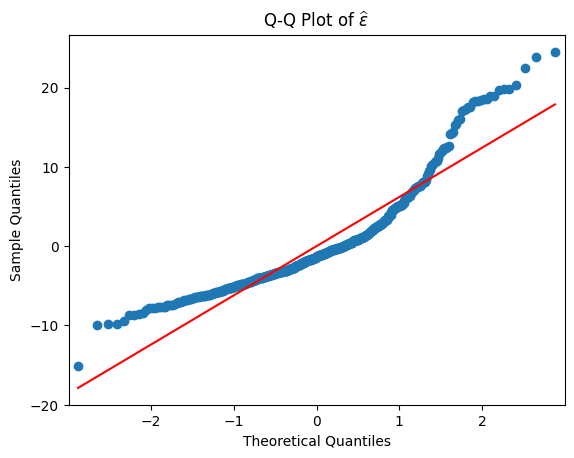

Shapiro-Wilk Test: 
W-statistic=0.879, 
p-value=1.8e-19

Not a normal distribution



In [73]:
qqplot(estimated_residuals, line="s")
plt.title(r"Q-Q Plot of $\widehat\varepsilon$")
plt.show()
shapiro_test = scipy.stats.shapiro(estimated_residuals)
print(
    f"Shapiro-Wilk Test: \nW-statistic={shapiro_test.statistic:.3}, \np-value={shapiro_test.pvalue:.3}"
)
if shapiro_test.pvalue < 0.05:
    print("\nNot a normal distribution\n")
else:
    print("\nIt is a normal distribution\n")

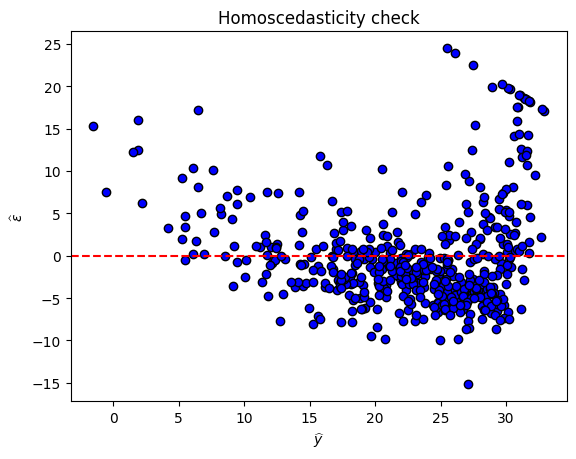

Lagrange multiplier statistic: 15.497473911490887
p-value: 8.261558615922159e-05
f-value: 15.923927882039068
f p-value: 7.572892652347984e-05

Heteroscedasticity: The variance is NOT constant



In [74]:
plt.scatter(y_hat, estimated_residuals, color="blue", edgecolor="k")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Homoscedasticity check")
plt.xlabel(r"$\widehat y$")
plt.ylabel(r"$\widehat\varepsilon$")
plt.show()

bp_test = het_breuschpagan(estimated_residuals, x_matrix)
labels = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test_results = dict(zip(labels, bp_test))

for k, v in test_results.items():
    print(f"{k}: {v}")

if test_results["f p-value"] < 0.05:
    print("\nHeteroscedasticity: The variance is NOT constant\n")
else:
    print("\nHomoscedasticity: The variance is constant\n")

In [75]:
p_value = results.pvalues.iloc[1]
print(results.summary())
print(f"{p_value=}")

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Mon, 04 Nov 2024   Prob (F-statistic):           5.08e-88
Time:                        00:56:12   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.5538      0.563     61.415      0.0

好的，既然原始假设（正态性和方差恒定性）未被满足，我们可以选择其他列来重新进行回归分析：

1. **选择新的变量**：使用 `rm` 作为自变量，`medv` 作为因变量。
2. **拟合线性模型**：对新的变量组合拟合线性回归模型。
3. **检查残差分布**：确认残差是否接近正态分布。
4. **检查同方差性**：确认残差的方差是否恒定。
5. **重新进行假设检验**：检验新的回归系数是否显著。

接下来可以进行分析并检查这些假设条件。

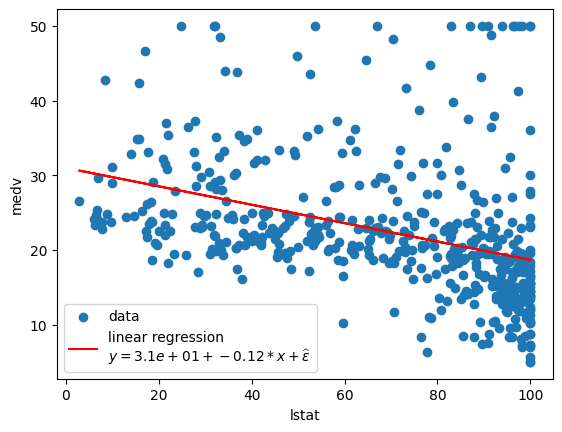

In [76]:
x_column_name = "age"
y_column_name = "medv"

x_column = data_boston[x_column_name]
y_column = data_boston[y_column_name]

x_matrix = add_constant(x_column)
y = y_column
model = OLS(y, x_matrix)
results = model.fit()

beta_0_hat, beta_1_hat = results.params
y_hat = results.predict(x_matrix)

plt.scatter(x_column, y_column, label="data")
plt.plot(
    x_column,
    y_hat,
    "r",
    label="linear regression \n"
    rf"$y = {beta_0_hat:.2} + {beta_1_hat:.2} * x + \widehat\varepsilon$",
)
plt.legend()
plt.xlabel("lstat")
plt.ylabel("medv")
plt.show()

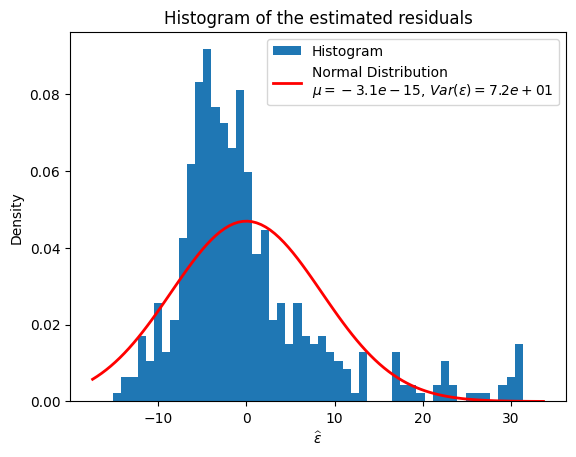

In [77]:
estimated_residuals = results.resid

plt.hist(estimated_residuals, bins=50, density=True, label="Histogram")
xmin, xmax = plt.xlim()

mean, std_dev = np.mean(estimated_residuals), np.std(estimated_residuals)
x_normal = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x_normal, mean, std_dev)

plt.plot(
    x_normal,
    p,
    "r",
    linewidth=2,
    label="Normal Distribution\n"
    rf"$\mu={mean:.2}$, $Var(\varepsilon)={np.var(estimated_residuals):.2}$",
)

plt.legend()
plt.title("Histogram of the estimated residuals")
plt.xlabel(r"$\widehat\varepsilon$")
plt.ylabel("Density")
plt.show()

Shapiro-Wilk Test: 
W-statistic=0.851, 
p-value=1.79e-21

Not a normal distribution



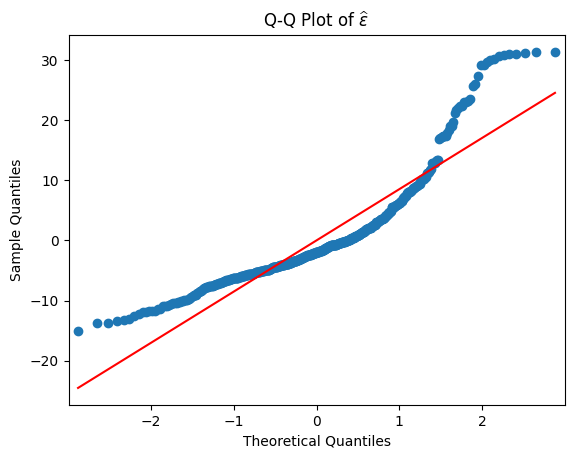

In [78]:
qqplot(estimated_residuals, line="s")
plt.title(r"Q-Q Plot of $\widehat\varepsilon$")
shapiro_test = scipy.stats.shapiro(estimated_residuals)
print(
    f"Shapiro-Wilk Test: \nW-statistic={shapiro_test.statistic:.3}, \np-value={shapiro_test.pvalue:.3}"
)
if shapiro_test.pvalue < 0.05:
    print("\nNot a normal distribution\n")
else:
    print("\nIt is a normal distribution\n")

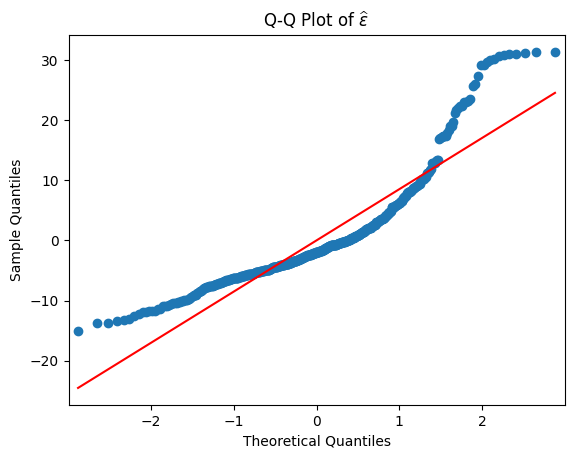

Shapiro-Wilk Test: 
W-statistic=0.851, 
p-value=1.79e-21

Not a normal distribution



In [79]:
qqplot(estimated_residuals, line="s")
plt.title(r"Q-Q Plot of $\widehat\varepsilon$")
plt.show()
shapiro_test = scipy.stats.shapiro(estimated_residuals)
print(
    f"Shapiro-Wilk Test: \nW-statistic={shapiro_test.statistic:.3}, \np-value={shapiro_test.pvalue:.3}"
)
if shapiro_test.pvalue < 0.05:
    print("\nNot a normal distribution\n")
else:
    print("\nIt is a normal distribution\n")

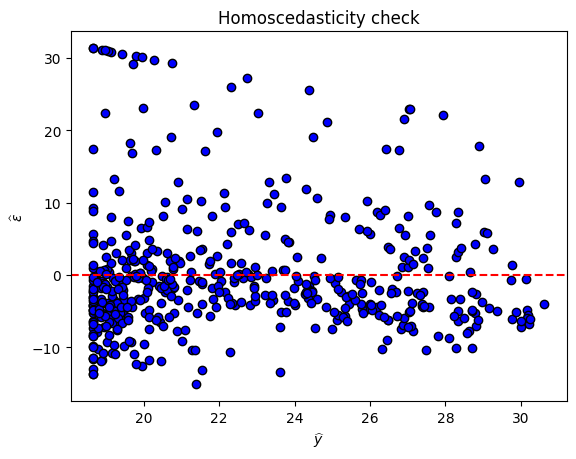

Lagrange multiplier statistic: 4.779941705097605
p-value: 0.028793095395238784
f-value: 4.806452933197968
f p-value: 0.028809860026292402

Heteroscedasticity: The variance is NOT constant



In [80]:
plt.scatter(y_hat, estimated_residuals, color="blue", edgecolor="k")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Homoscedasticity check")
plt.xlabel(r"$\widehat y$")
plt.ylabel(r"$\widehat\varepsilon$")
plt.show()

bp_test = het_breuschpagan(estimated_residuals, x_matrix)
labels = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test_results = dict(zip(labels, bp_test))

for k, v in test_results.items():
    print(f"{k}: {v}")

if test_results["f p-value"] < 0.05:
    print("\nHeteroscedasticity: The variance is NOT constant\n")
else:
    print("\nHomoscedasticity: The variance is constant\n")

In [81]:
p_value = results.pvalues.iloc[1]
print(results.summary())
print(f"{p_value=}")

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     83.48
Date:                Mon, 04 Nov 2024   Prob (F-statistic):           1.57e-18
Time:                        00:56:13   Log-Likelihood:                -1801.5
No. Observations:                 506   AIC:                             3607.
Df Residuals:                     504   BIC:                             3615.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.9787      0.999     31.006      0.0